# Forecasting with `sktime`

**OBJECTIVES**

- Basic forecasting workflow with `sktime` library
- Exponential Smoothing models
- Holt Winters Model
- Autoregression
- ARIMA Models

Today we will cover some basic time series forecasting models and further use `sktime` to implement time series forecasting models.  We will use data that is already prepared as we discussed -- datetime index sorted in time.

### Time Series Forecasting Models



In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_openml
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### `sktime`

In [2]:
!pip install numpy==1.26.4 sktime


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import sktime as skt

In [4]:
!pip install numpy==1.26.4


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [5]:
from sktime.datasets import load_airline, load_lynx
from sktime.utils.plotting import plot_correlations, plot_series

### Visualizing Time Series

Initially, it is important to consider a plot of the series.  Here, we are looking at the very least to see if the series has a trend or some kind of seasonality. We will typically also look to the autocorrelation and partial autocorrelation plot.

- `plot_series`
- `plot_correlations`

In [6]:
lynx = load_lynx()

In [7]:
plot_series(lynx);

ImportError: cannot import name '_check_estimator_deps' from 'skbase.utils.dependencies' (/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skbase/utils/dependencies/__init__.py)

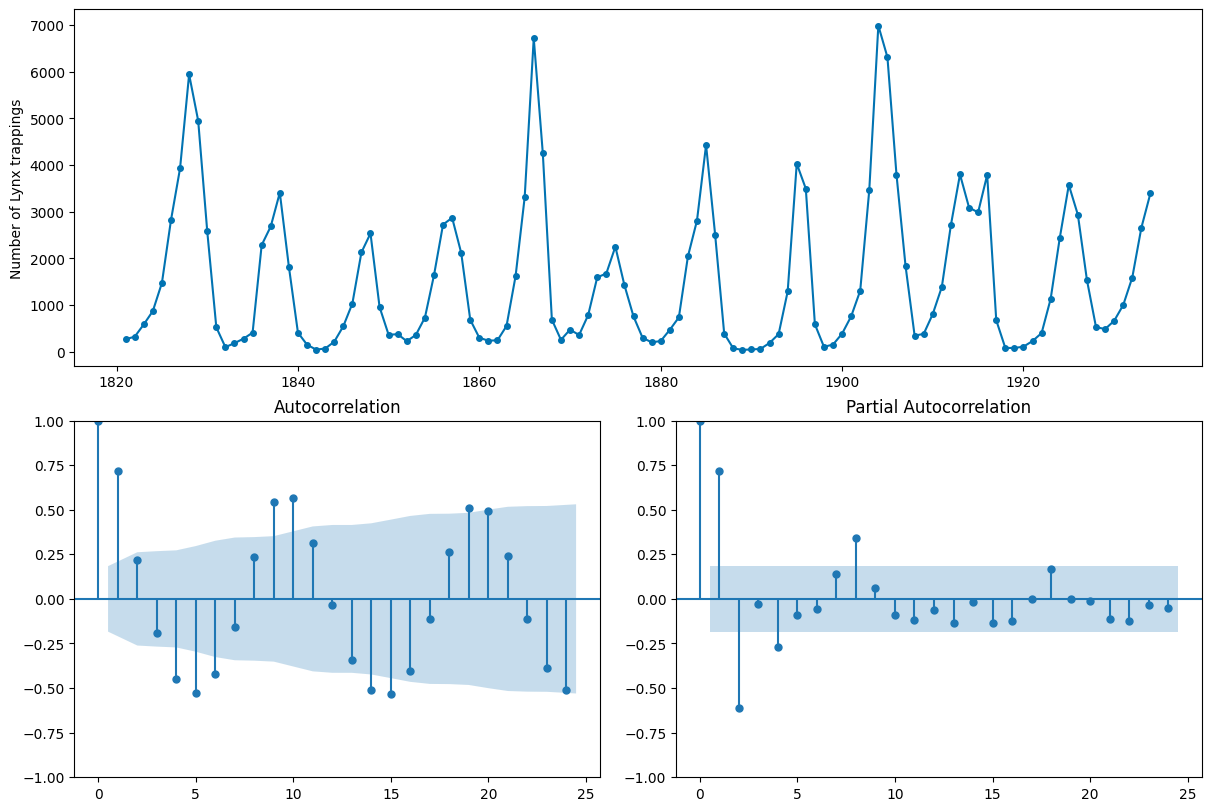

In [ ]:
plot_correlations(lynx);

### Forecasting with `sktime`

In [ ]:
from sktime.datasets import load_airline

In [ ]:
airline = load_airline()

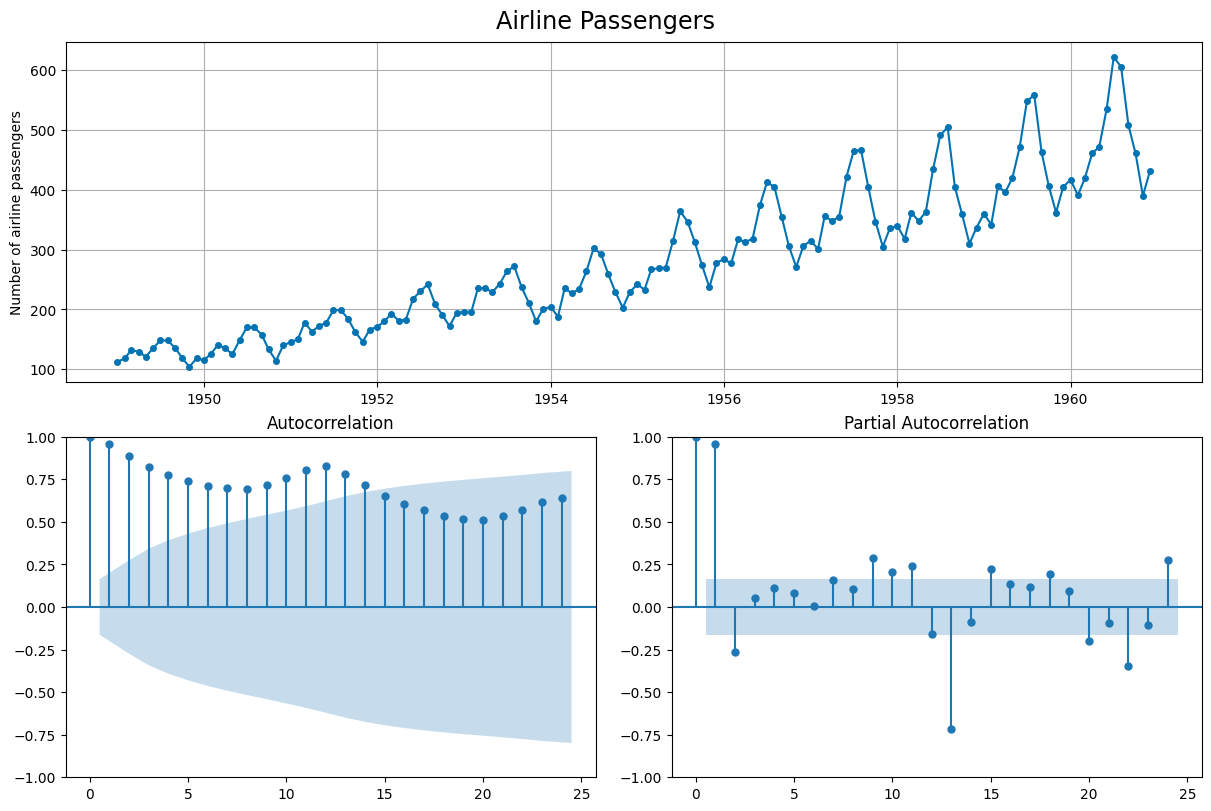

In [ ]:
_, ax = plot_correlations(airline, suptitle = 'Airline Passengers')
ax[0].grid()

In [ ]:
from sktime.split import temporal_train_test_split

In [ ]:
X_train, X_test = temporal_train_test_split(airline)

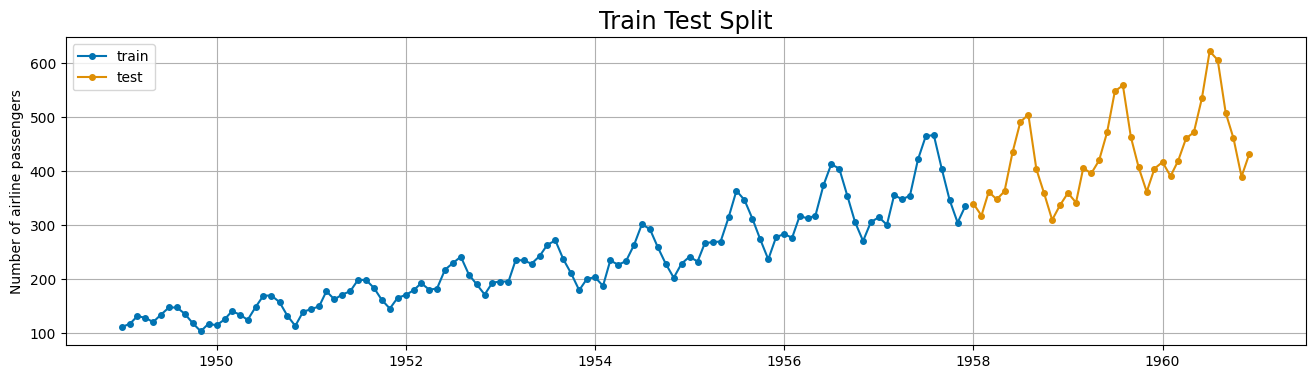

In [ ]:
plot_series(X_train, X_test, labels = ['train', 'test'], title = 'Train Test Split')
plt.grid();

### Baseline Model

The `NaiveForecaster` provides multiple strategies for baseline predicitions.  What does `stragey = 'drift'` do?  Plot the predictions along with the train and test data adding appropriate labels.  

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

In [ ]:
#number of time steps to forecast
fh = np.arange(1, len(X_test)+1)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

In [ ]:
#instantiate
forecaster = NaiveForecaster(strategy = 'drift')
#fit model
forecaster.fit(X_train)
#predict for horizon
yhat = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

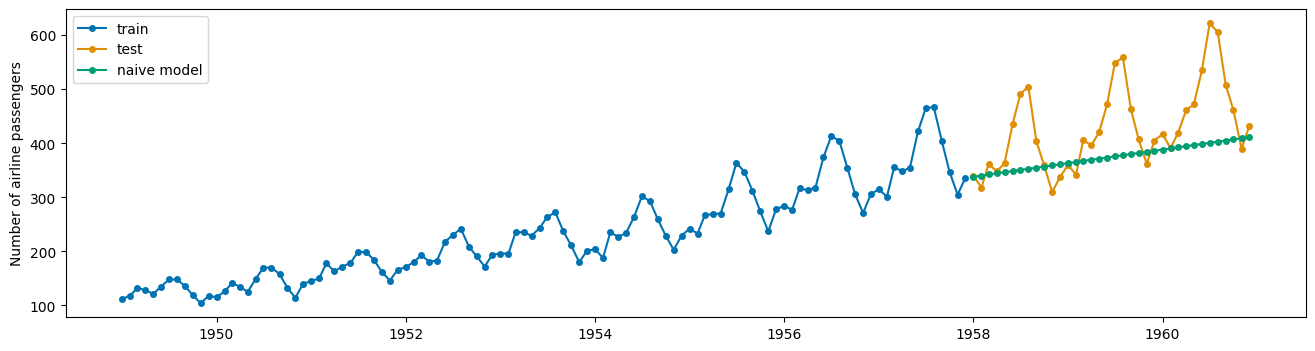

In [ ]:
#plot the predictions using plot_series
plot_series(X_train, X_test, yhat, labels = ['train', 'test', 'naive model'])

### Evaluating predictions

`sktime` implements many evaluation metrics.  Below, the `MeanAbsolutePercentageError` class is instantiated and used to evaluated the naive baseline.  Per usual, lower is better.

In [ ]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [ ]:
mae = MeanAbsolutePercentageError()

In [ ]:
mae(X_test, yhat)

0.1299046419013891

### Exponential Smoothing

The weighted moving average model -- very basic and simple; predicts the same value over and over.

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

In [ ]:
#instantiate
exp = ExponentialSmoothing()

In [ ]:
#fit the model
exp.fit(X_train)

ExponentialSmoothing()

In [ ]:
#predict
exp_preds = exp.predict(fh)

In [ ]:
#evaluate
mae(X_test, exp_preds)

0.19886712021864697

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

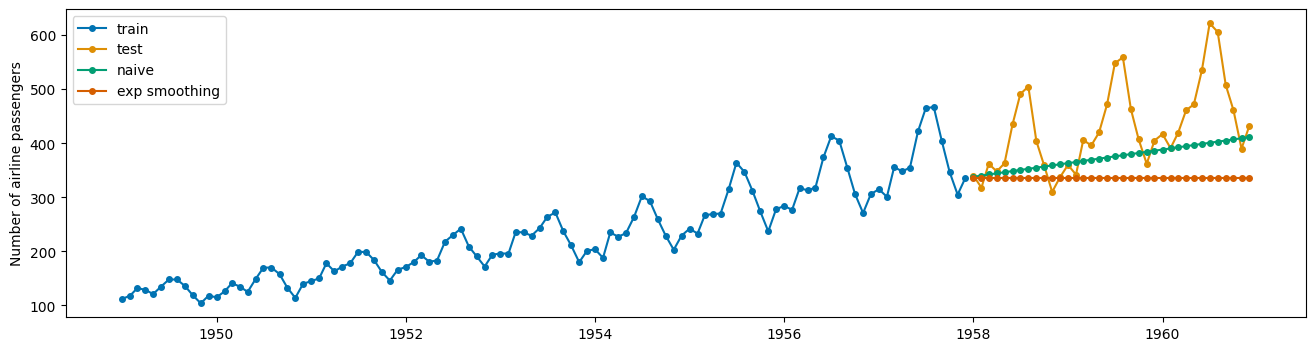

In [ ]:
#plot the series
plot_series(X_train, X_test, yhat, exp_preds, labels = ['train', 'test', 'naive', 'exp smoothing'])

### Holt Winters Model

Triple Exponential Smoothing where trend and seasonality are considered.  Below, a holt winters model is implemented.

- trend: always additive
- seasonality: additive if same each season, multiplicative if growing
- sp: timesteps in a season

**QUESTION**: What kind of seasonality should we use here -- additive or multiplicative?  Why?

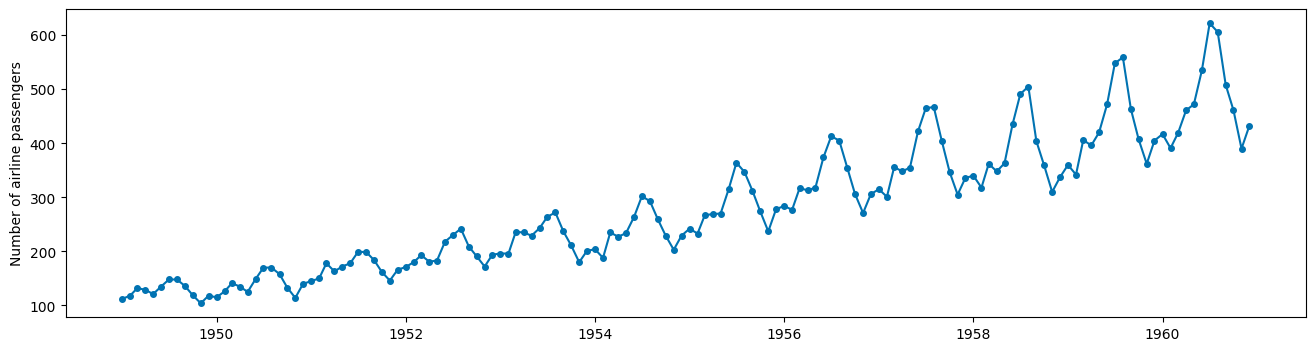

In [ ]:
#what kind of seasonality?
plot_series(airline);

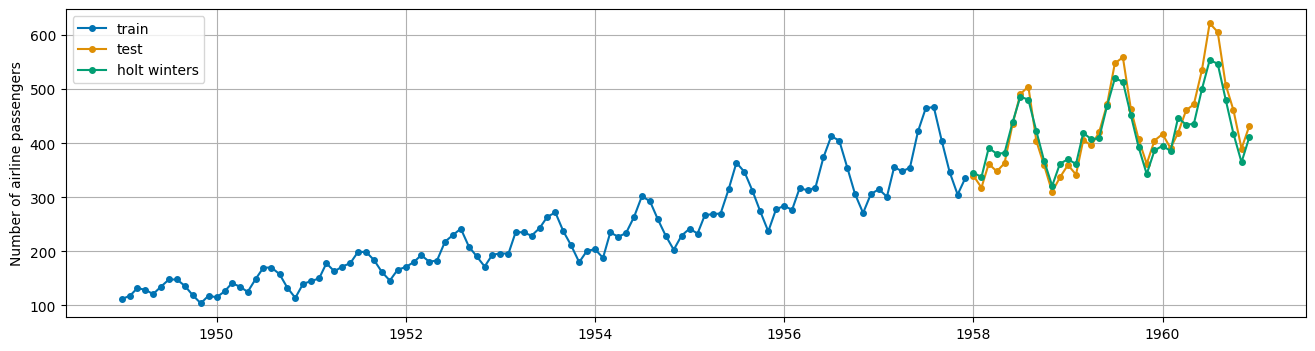

In [ ]:
hw = ExponentialSmoothing(trend = 'add', seasonal='mul', sp = 12)
hw.fit(X_train)
hw_preds = hw.predict(fh)
plot_series(X_train, X_test, hw_preds,
            labels = ['train', 'test', 'holt winters'],
           )
plt.grid();

In [ ]:
mae(X_test, hw_preds)

0.05056484561299068

### Stationarity and Differencing

Regression models in time series will also have assumptions about the data, namely that the data we model is **stationary**.  Stationary data has constant mean and variance -- thus trends and seasonality are not a part of stationary time series.

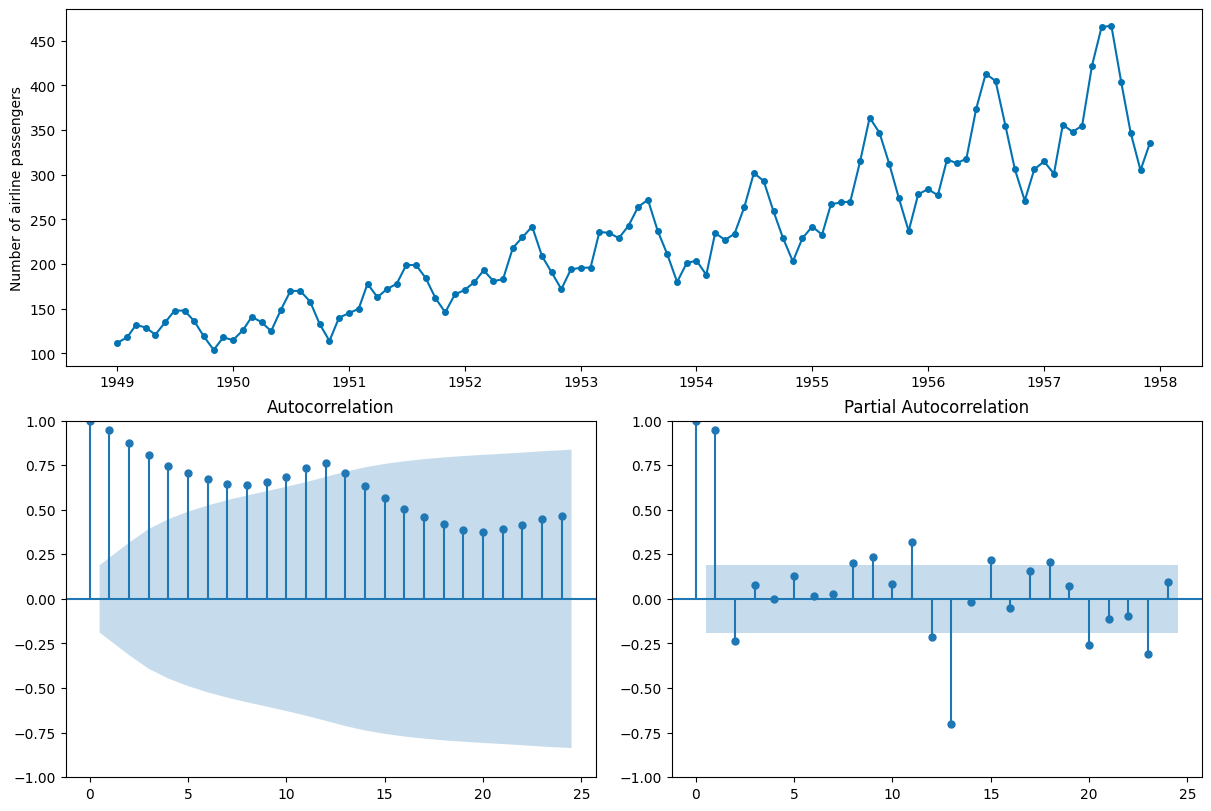

In [ ]:
plot_correlations(X_train);

**QUESTION**: Which of the time series pictured below are stationary?  

![](images/stationary-1.png)

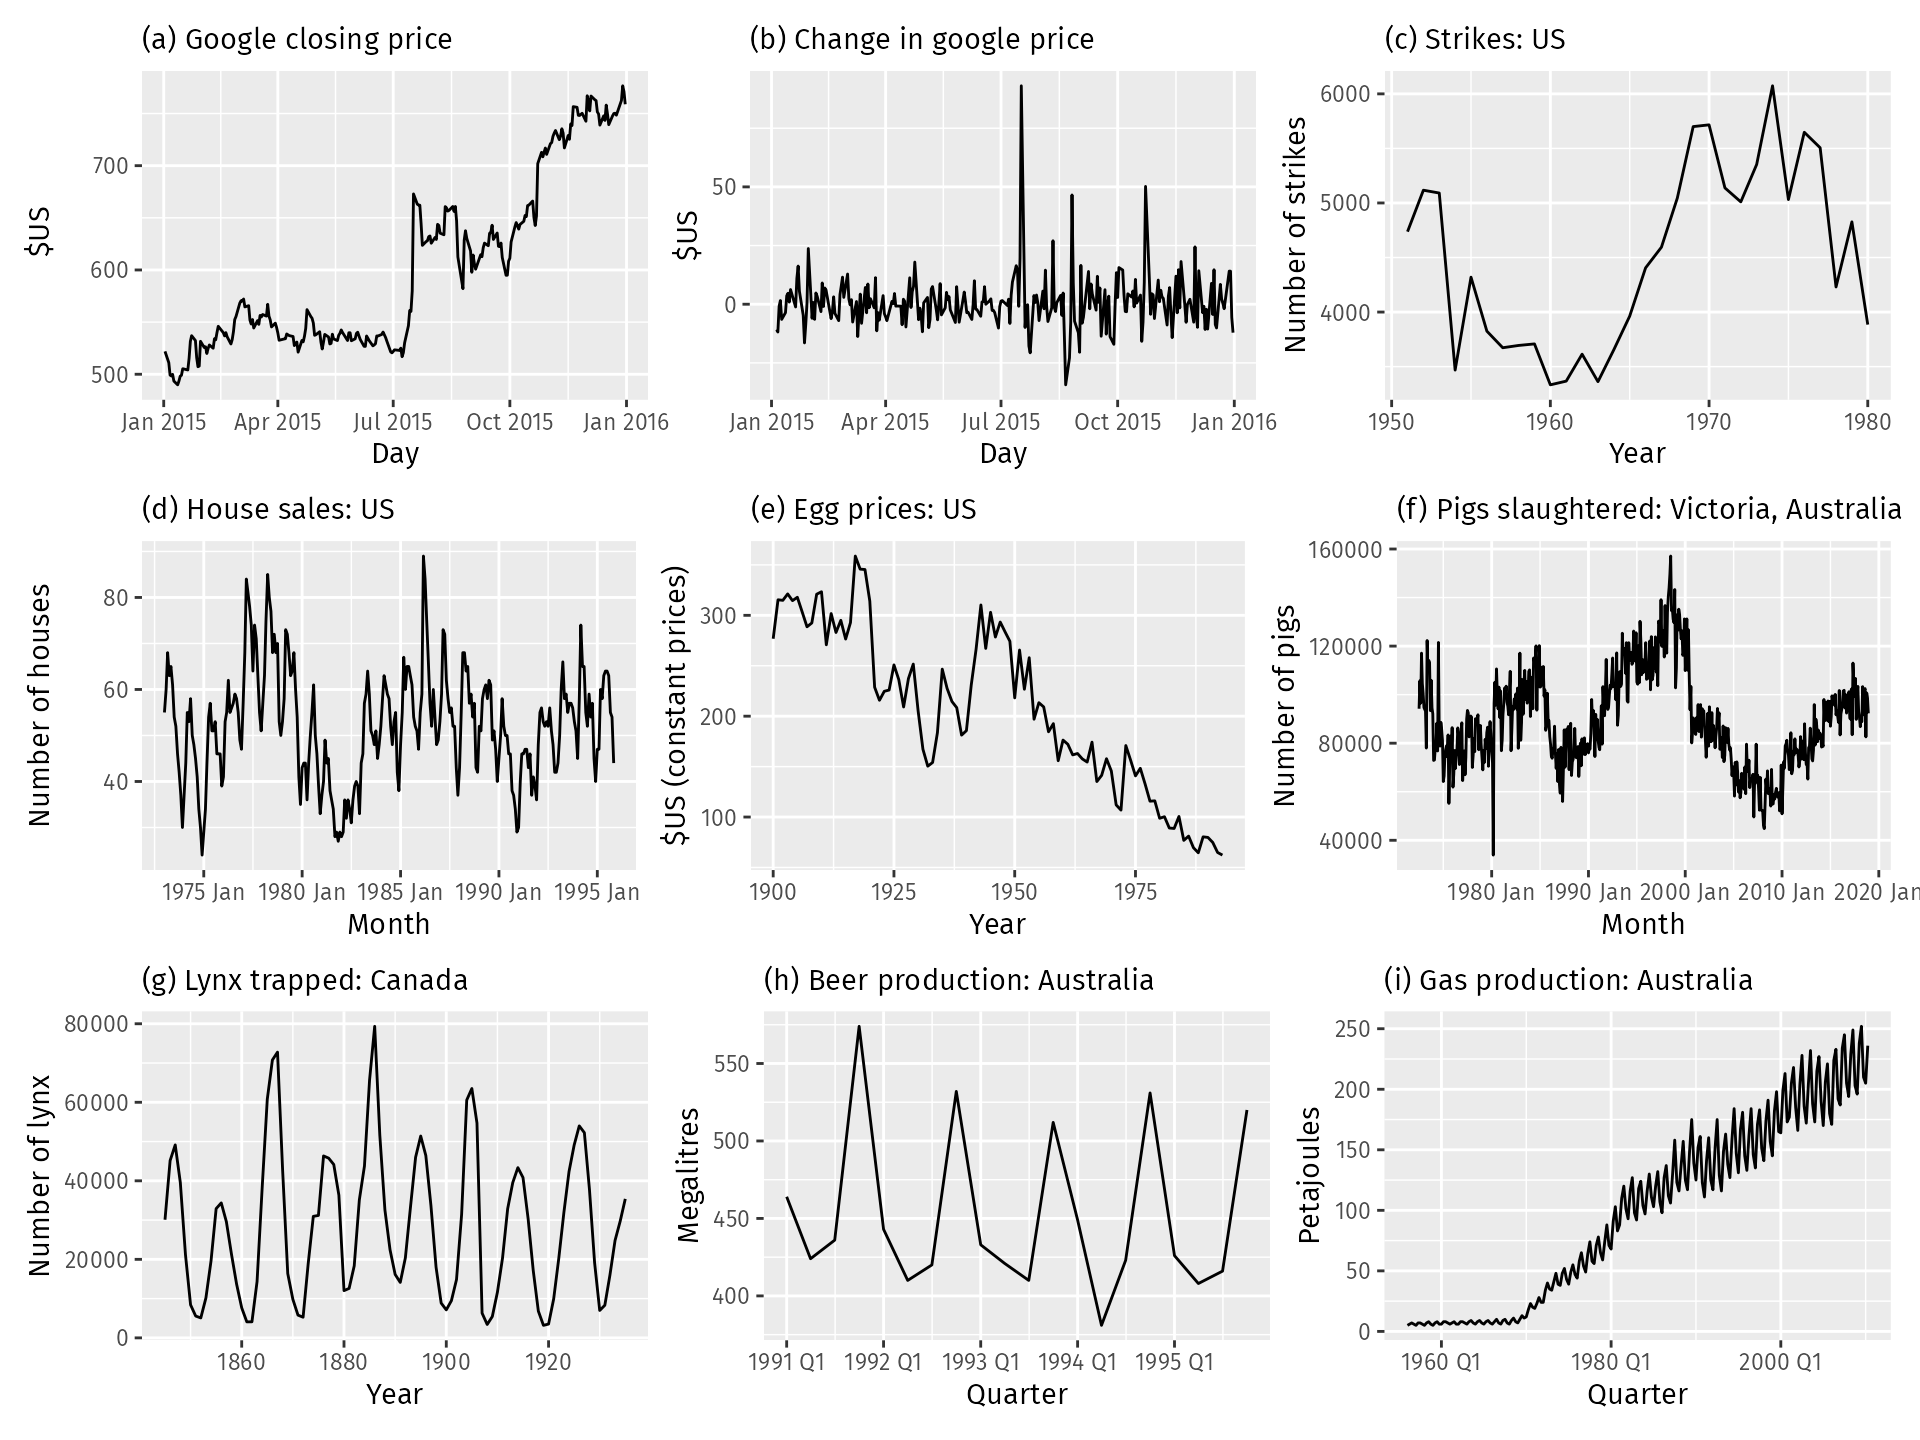

### Differencing the Data

One way to remove the trend is to difference the data.  Compare the resulting autocorrelation plot to the undifferenced data.

In [ ]:
X_train.diff(1).head()

,Number of airline passengers
1949-01,NaN
1949-02,6.0
1949-03,14.0
1949-04,-3.0
1949-05,-8.0


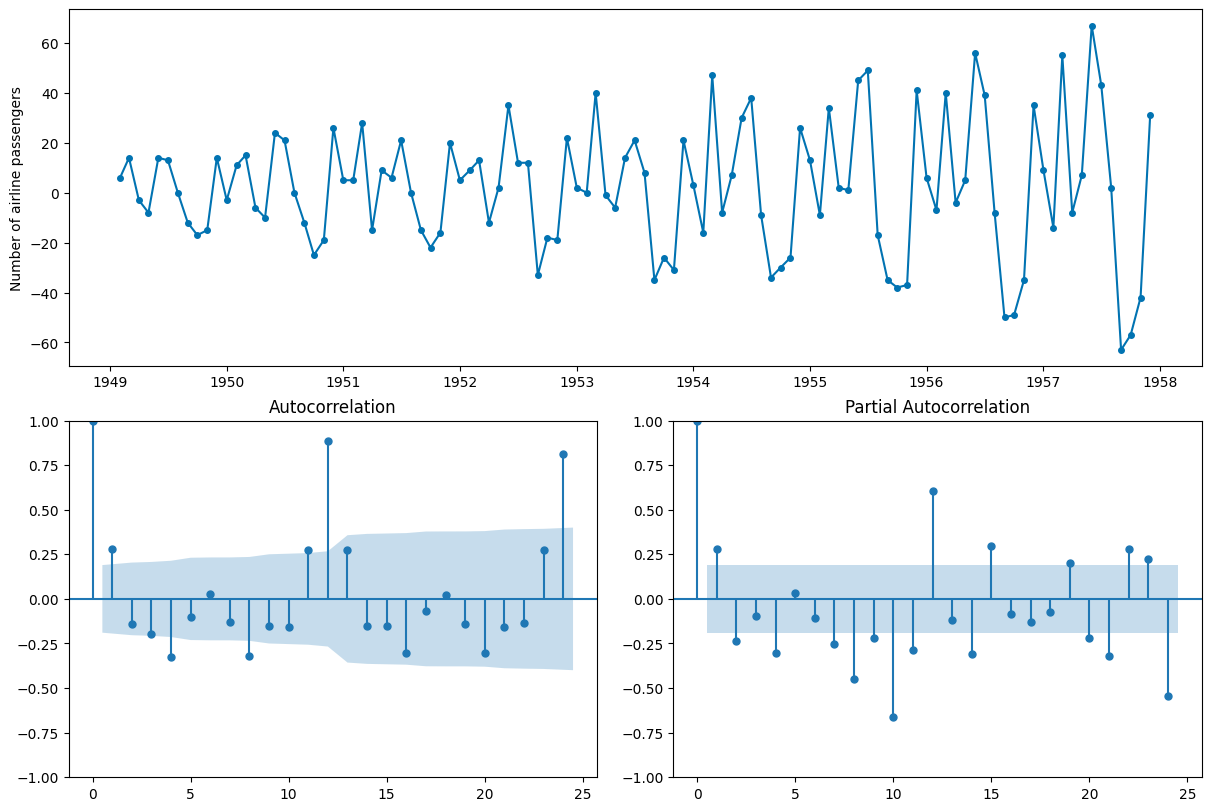

In [ ]:
plot_correlations(X_train.diff(1).dropna());

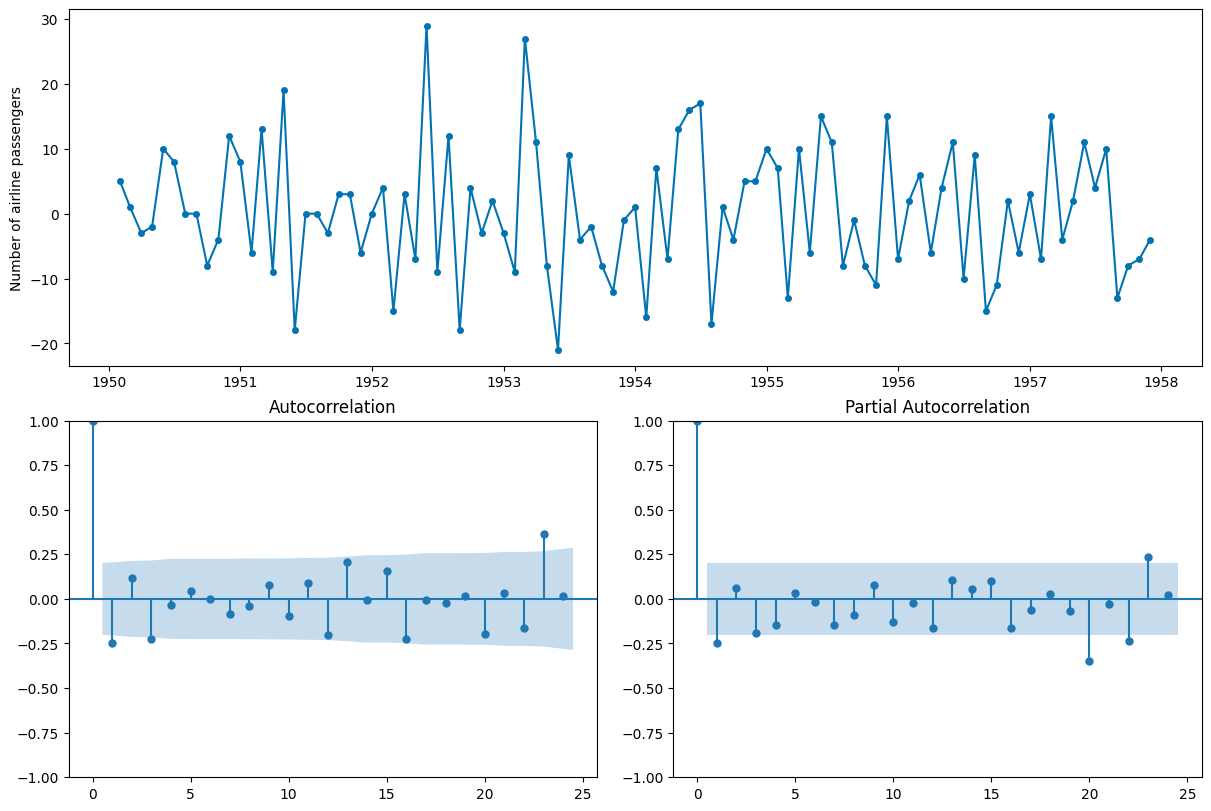

In [ ]:
#seasonal differencing to try to remove seasonality -- t and t-12
plot_correlations(X_train.diff(1).diff(12).dropna());

### AutoRegression

Similar to regression however the regression is on previous time steps or "lags".

$$AR(p) = c + \theta_1 y_{t - 1} + \theta_2 y_{t - 2} + ... + \theta_n y_{t - p} + \epsilon$$

In [ ]:
from sktime.forecasting.auto_reg import AutoREG

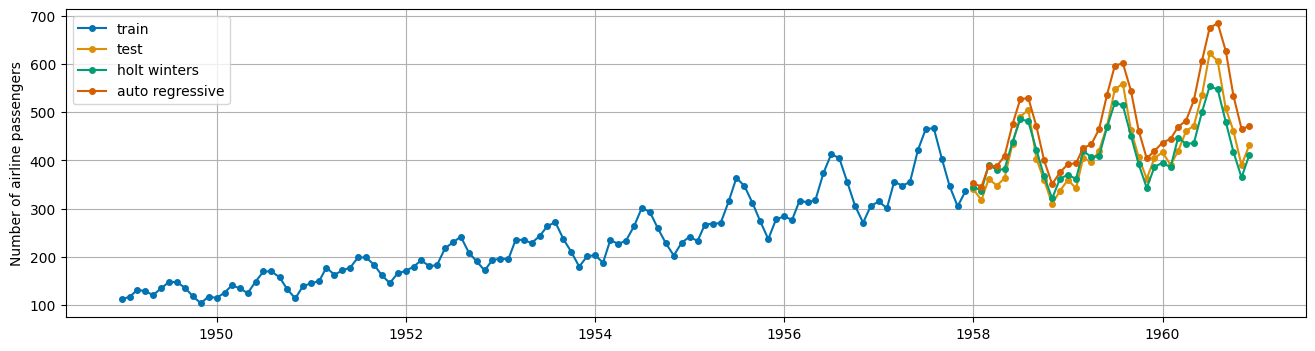

In [ ]:
ar = AutoREG(lags = 12)
ar.fit(X_train)
ar_preds = ar.predict(fh)
plot_series(X_train, X_test, hw_preds, ar_preds,
            labels = ['train', 'test', 'holt winters', 'auto regressive'],
           )
plt.grid();

In [ ]:
ar.get_fitted_params()

{'aic': 757.542243633855,
 'aicc': 762.7274288190403,
 'bic': 793.4431183144047,
 'hqic': 772.0539637923447,
 'const': 2.9873776849433913,
 'Number of airline passengers.L1': 0.44024802821861986,
 'Number of airline passengers.L2': -0.24712930495045504,
 'Number of airline passengers.L3': 0.19596577672853766,
 'Number of airline passengers.L4': -0.23300070381218374,
 'Number of airline passengers.L5': 0.23078858354056853,
 'Number of airline passengers.L6': -0.17243176175515718,
 'Number of airline passengers.L7': 0.14303113614100504,
 'Number of airline passengers.L8': -0.22605487868090757,
 'Number of airline passengers.L9': 0.22902051756885222,
 'Number of airline passengers.L10': -0.22421839988764436,
 'Number of airline passengers.L11': 0.31903131528237716,
 'Number of airline passengers.L12': 0.634091273318222}

In [ ]:
mae(X_test, ar_preds)

0.10913989054791079

**PROBLEM**: Adjusting for lags.  Consider an autoregressive model that uses the 12 previous time steps to forecast.  Is this model better?  Plot the results.

### ARIMA models

- `AR`: Autoregressive component as above
- `MA`: Moving average of errors

$$MA(q) = c + \epsilon_t + \theta_1 \epsilon_{t+1} + ... + \theta_q \epsilon_{t - q}$$
- `ARIMA`: Autoregressive integrated moving average

$$ARIMA(p, q, d) = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t - p} + \theta_1 \epsilon_{t-1} + ... + \epsilon_{t - q} + \epsilon_t$$

- $p$: order of autoregressive component
- $q$: order of moving average component
- $d$: order of differences of series



In [ ]:
from sktime.forecasting.arima import ARIMA

In [ ]:
arima = ARIMA(order = (1, 1, 1))

In [ ]:
arima.fit(X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARIMA(order=(1, 1, 1))

In [ ]:
arima_preds = arima.predict(fh)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

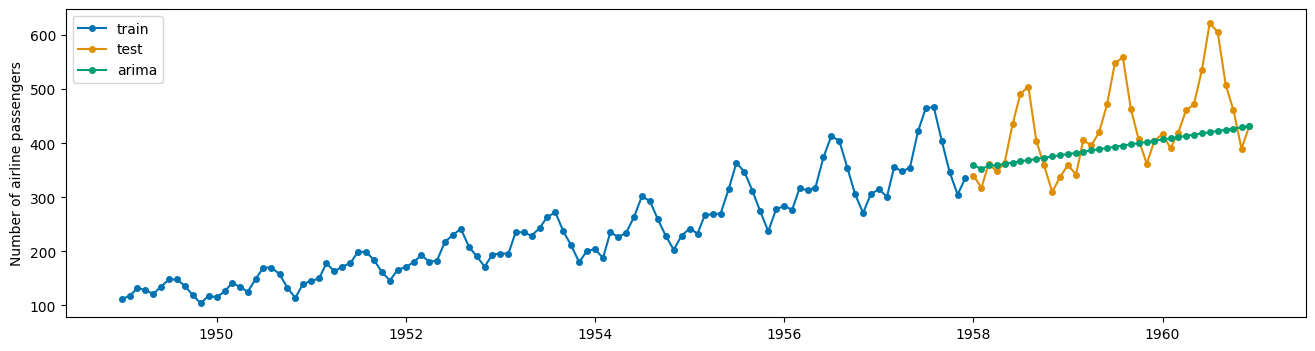

In [ ]:
plot_series(X_train, X_test, arima_preds, labels = ['train', 'test', 'arima'])

**PROBLEM**

Try to fit an AutoARIMA model (automatically selects $p,q,d$).  How does this model perform?

In [ ]:
from sktime.forecasting.arima import AutoARIMA

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

0.1165416922500279


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

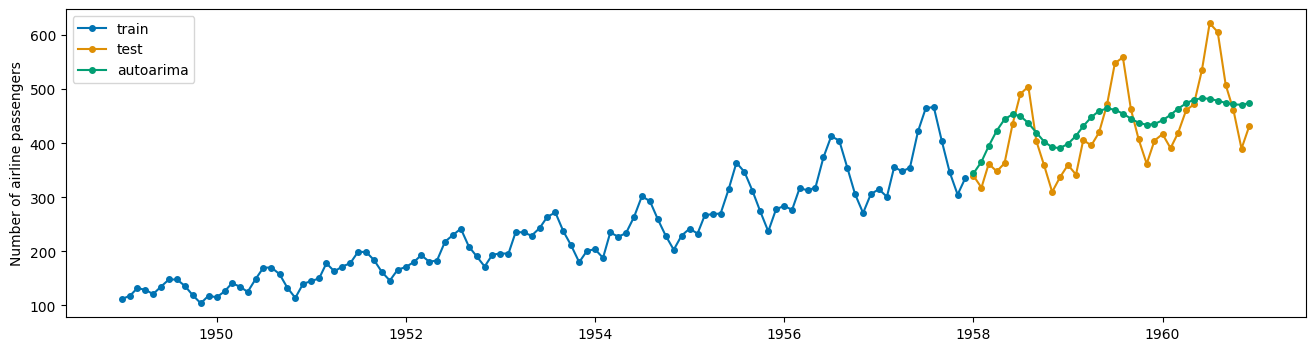

In [ ]:
#instantiate
auto_ar = AutoARIMA()
#fit
auto_ar.fit(X_train)
#predict
auto_preds = auto_ar.predict(fh)
#print mape
print(mae(X_test, auto_preds))
#plot predictions
plot_series(X_train, X_test, auto_preds, labels = ['train', 'test', 'autoarima'])

In [ ]:
auto_ar.get_fitted_params()

{'intercept': 0.670814501472786,
 'ar.L1': 1.6405373906253153,
 'ar.L2': -0.9086369026442623,
 'ma.L1': -1.8337763252599235,
 'ma.L2': 0.9289381283312711,
 'sigma2': 393.31775090032295,
 'order': (2, 1, 2),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 959.2179634640431,
 'aicc': 960.0579634640432,
 'bic': 975.2549364708145,
 'hqic': 965.7191390771806}

#### Example: Shampoo Sales

In [ ]:
from sktime.datasets import load_shampoo_sales

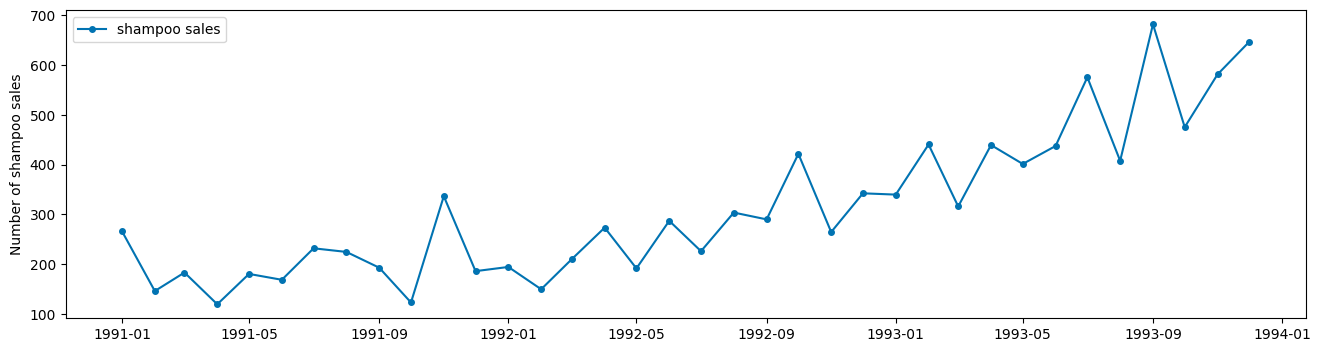

In [ ]:
shampoo = load_shampoo_sales()
plot_series(shampoo, labels = ['shampoo sales']);

**PROBLEM**

Split the data into train and test sets to build a Holt Winters model and AutoARIMA model.  Compare performance on the test data and plot the resulting predictions using `plot_series` with appropriate labels.

**Readings or Watchings**:

- Chapter 8.1 - 8.4 of Hyndman [here](https://otexts.com/fpp3/expsmooth.html)
- Chapter 9 of Hyndman on ARIMA models [here](https://otexts.com/fpp3/arima.html#arima)